In [ ]:
%pip install cartopy
%pip install geopy
%pip install Basemap

In [ ]:
import pandas as pd

flows = pd.read_csv('trade-2021-flows.csv')
nodes_countries = pd.read_csv('trade-countries.csv', sep='\t')

In [23]:
flows[['from', 'to', 'amount']] = flows['from\tto\tamount'].str.split("\t", expand=True)
flows.drop(columns=['from\tto\tamount'], inplace=True)

flows.head()

,from,to,amount
0,AUS,ARG,156251292
1,AUS,AUT,39474862
2,AUS,BEL,965550384
3,AUS,BRA,1348659969
4,AUS,CAN,1045200786


In [5]:
nodes_countries.head()

,code,name
0,AUS,Australia
1,AUT,Austria
2,BEL,Belgium
3,CAN,Canada
4,CHE,Switzerland


In [26]:
flows["amount"].dtype
flows['amount'] = pd.to_numeric(flows['amount'])

# Question 1

In [24]:
flows.columns

Index(['from', 'to', 'amount'], dtype='object')

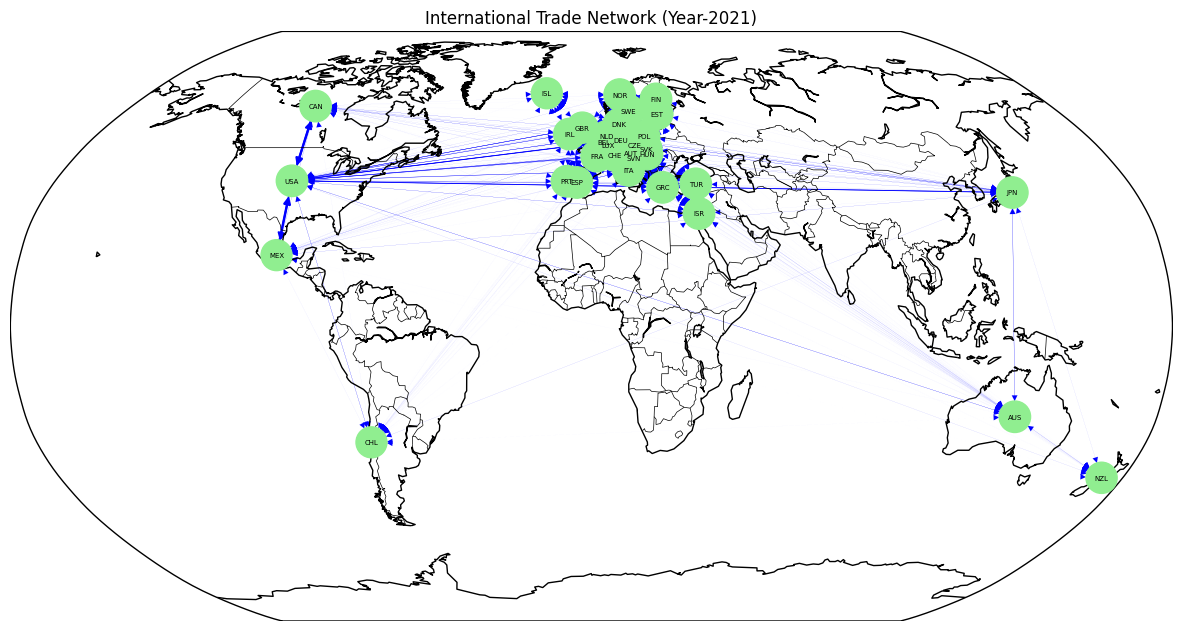

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import pandas as pd

# Create a dictionary to map country codes to country names
country_names = dict(zip(nodes_countries['code'], nodes_countries['name']))

# Create a directed graph
G = nx.DiGraph()

# Add nodes (countries) to the graph
G.add_nodes_from(nodes_countries['code'])

# Add edges (trade flows) to the graph
for index, row in flows.iterrows():
    source = row['from']
    target = row['to']
    amount = row['amount']
    if source in country_names and target in country_names:
        G.add_edge(source, target, weight=float(amount))  # Convert amount to float

# Calculate node degrees
node_degrees = dict(G.degree)

# Calculate edge weights
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

# Get coordinates for countries
geolocator = Nominatim(user_agent="trade_network_visualization")
country_locations = {}

# Manually adjust coordinates for Greece to position it correctly in Europe
country_locations['GRC'] = (23.727539, 37.983810)

for country_code in nodes_countries['code']:
    if country_code != 'GRC':  # Skip Greece to prevent overwriting the adjusted coordinates
        country_name = country_names.get(country_code, "")
        if country_name:
            location = geolocator.geocode(country_name)
            if location:
                country_locations[country_code] = (location.longitude, location.latitude)

# Draw the world map
plt.figure(figsize=(15, 10))

m = Basemap(projection='robin', lon_0=0, resolution='c')
m.drawcoastlines()
m.drawcountries()

# Convert coordinates to Basemap projection
x, y = m([coord[0] for coord in country_locations.values()], [coord[1] for coord in country_locations.values()])

# Draw nodes and edges
pos = {country: m(lon, lat) for country, (lon, lat) in country_locations.items()}
nx.draw(G, pos, with_labels=True, node_size=[node_degrees[node] * 8 for node in G.nodes()],
        node_color='lightgreen', font_size=5, edge_color='blue',
        width=[float(w) / max(edge_weights) * 1.75 for w in edge_weights])
plt.title('International Trade Network (Year-2021)')
plt.show()


In [62]:
print(G)

DiGraph with 33 nodes and 1049 edges


# Question 2

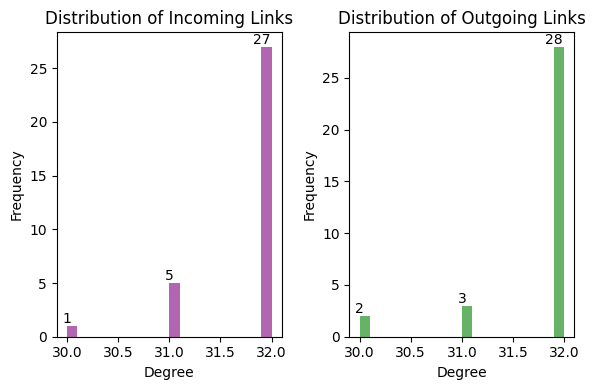

In [67]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Determine the distributions of indegree and outdegree
in_degrees = [degree for node, degree in G.in_degree()]
out_degrees = [degree for node, degree in G.out_degree()]

# Visualize the distributions
plt.figure(figsize=(6, 4))

# Plot the indegree distribution
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(in_degrees, bins=20, color='purple', alpha=0.6)
plt.title('Distribution of Incoming Links')
plt.xlabel('Degree')
plt.ylabel('Frequency')

# Add annotations to the non-zero bars
for i in range(len(patches)):
    if n[i] > 0:
        plt.text(x=bins[i], y=n[i], s=str(int(n[i])), ha='center', va='bottom')

# Plot the outdegree distribution
plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(out_degrees, bins=20, color='green', alpha=0.6)
plt.title('Distribution of Outgoing Links')
plt.xlabel('Degree')
plt.ylabel('Frequency')

# Add annotations to the non-zero bars
for i in range(len(patches)):
    if n[i] > 0:
        plt.text(x=bins[i], y=n[i], s=str(int(n[i])), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [47]:
import scipy.stats as stats

# Fit the degree distributions to a probability distribution
in_params = stats.powerlaw.fit(in_degrees)
out_params = stats.powerlaw.fit(out_degrees)

# Perform goodness-of-fit tests
# For example, perform a Kolmogorov-Smirnov test
in_ks_statistic, in_p_value = stats.kstest(in_degrees, 'powerlaw', args=in_params)
out_ks_statistic, out_p_value = stats.kstest(out_degrees, 'powerlaw', args=out_params)

# Print the results of the goodness-of-fit tests
print("In-degree distribution:")
print(f"Kolmogorov-Smirnov test statistic: {in_ks_statistic}")
print(f"P-value: {in_p_value}")

print("\nOut-degree distribution:")
print(f"Kolmogorov-Smirnov test statistic: {out_ks_statistic}")
print(f"P-value: {out_p_value}")

print()

# Evaluate the goodness-of-fit measures
if in_p_value < 0.05:
    print("Reject the null hypothesis for in-degree distribution.")
else:
    print("Fail to reject the null hypothesis for in-degree distribution.")

if out_p_value < 0.05:
    print("Reject the null hypothesis for out-degree distribution.")
else:
    print("Fail to reject the null hypothesis for out-degree distribution.")


In-degree distribution:
Kolmogorov-Smirnov test statistic: 0.8181818007228523
P-value: 1.0910276146255694e-24

Out-degree distribution:
Kolmogorov-Smirnov test statistic: 0.848484834163746
P-value: 2.071638270759745e-27

Reject the null hypothesis for in-degree distribution.
Reject the null hypothesis for out-degree distribution.


# Question 3

In [48]:
from scipy.stats import pearsonr

# Compute centrality measures for the network
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Extract centrality values for each node
in_degree_values = np.array(list(in_degree_centrality.values()))
out_degree_values = np.array(list(out_degree_centrality.values()))
betweenness_values = np.array(list(betweenness_centrality.values()))
closeness_values = np.array(list(closeness_centrality.values()))
eigenvector_values = np.array(list(eigenvector_centrality.values()))

# Calculate Pearson correlation coefficients
pearson_in_degree_betweenness, _ = pearsonr(in_degree_values, betweenness_values)
pearson_out_degree_betweenness, _ = pearsonr(out_degree_values, betweenness_values)
pearson_in_degree_closeness, _ = pearsonr(in_degree_values, closeness_values)
pearson_out_degree_closeness, _ = pearsonr(out_degree_values, closeness_values)
pearson_in_degree_eigenvector, _ = pearsonr(in_degree_values, eigenvector_values)
pearson_out_degree_eigenvector, _ = pearsonr(out_degree_values, eigenvector_values)

# Print the Pearson correlation coefficients
print("Pearson correlation between In-Degree and Betweenness Centrality:", pearson_in_degree_betweenness)
print("Pearson correlation between Out-Degree and Betweenness Centrality:", pearson_out_degree_betweenness, "\n")
print("Pearson correlation between In-Degree and Closeness Centrality:", pearson_in_degree_closeness)
print("Pearson correlation between Out-Degree and Closeness Centrality:", pearson_out_degree_closeness, "\n")
print("Pearson correlation between In-Degree and Eigenvector Centrality:", pearson_in_degree_eigenvector)
print("Pearson correlation between Out-Degree and Eigenvector Centrality:", pearson_out_degree_eigenvector, "\n")

Pearson correlation between In-Degree and Betweenness Centrality: 0.671515487824284
Pearson correlation between Out-Degree and Betweenness Centrality: 0.6540235839859018 

Pearson correlation between In-Degree and Closeness Centrality: 0.9998711235092689
Pearson correlation between Out-Degree and Closeness Centrality: -0.056646214409460154 

Pearson correlation between In-Degree and Eigenvector Centrality: 0.9999447512600123
Pearson correlation between Out-Degree and Eigenvector Centrality: -0.05674952711417494 



# Question 4

Pearson correlation coefficient between In-Degree Centrality and Node Strength: 0.24534178596837558


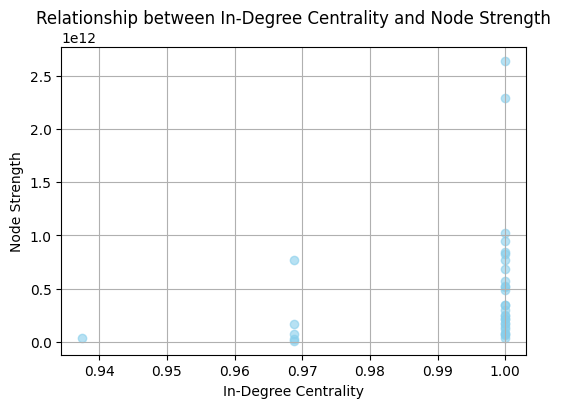

Pearson correlation coefficient between Out-Degree Centrality and Node Strength: 0.06920345565226008


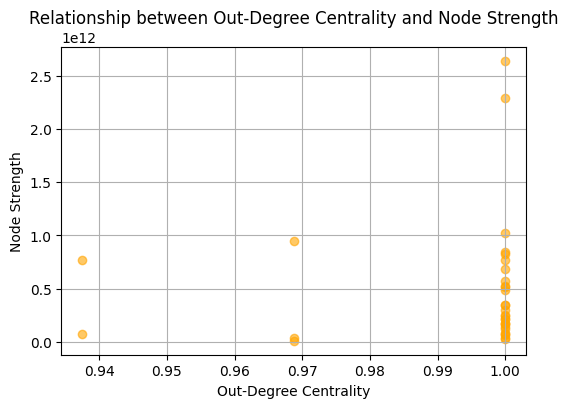

In [51]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute in-degree centrality, out-degree centrality, and node strength for each node in the network
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
node_strength = dict(G.degree(weight='weight'))

# Extract in-degree centrality, out-degree centrality, and node strength values for each node
in_degree_values = np.array(list(in_degree_centrality.values()))
out_degree_values = np.array(list(out_degree_centrality.values()))
strength_values = np.array(list(node_strength.values()))

# Plot the relationship between in-degree centrality and node strength
plt.figure(figsize=(6, 4))
plt.scatter(in_degree_values, strength_values, color='skyblue', alpha=0.6)
plt.title('Relationship between In-Degree Centrality and Node Strength')
plt.xlabel('In-Degree Centrality')
plt.ylabel('Node Strength')
plt.grid(True)

# Calculate the Pearson correlation coefficient for in-degree centrality and node strength
pearson_in_degree_strength, _ = pearsonr(in_degree_values, strength_values)
print("Pearson correlation coefficient between In-Degree Centrality and Node Strength:", pearson_in_degree_strength)

plt.show()

# Plot the relationship between out-degree centrality and node strength
plt.figure(figsize=(6, 4))
plt.scatter(out_degree_values, strength_values, color='orange', alpha=0.6)
plt.title('Relationship between Out-Degree Centrality and Node Strength')
plt.xlabel('Out-Degree Centrality')
plt.ylabel('Node Strength')
plt.grid(True)

# Calculate the Pearson correlation coefficient for out-degree centrality and node strength
pearson_out_degree_strength, _ = pearsonr(out_degree_values, strength_values)
print("Pearson correlation coefficient between Out-Degree Centrality and Node Strength:", pearson_out_degree_strength)

plt.show()

# Question 5

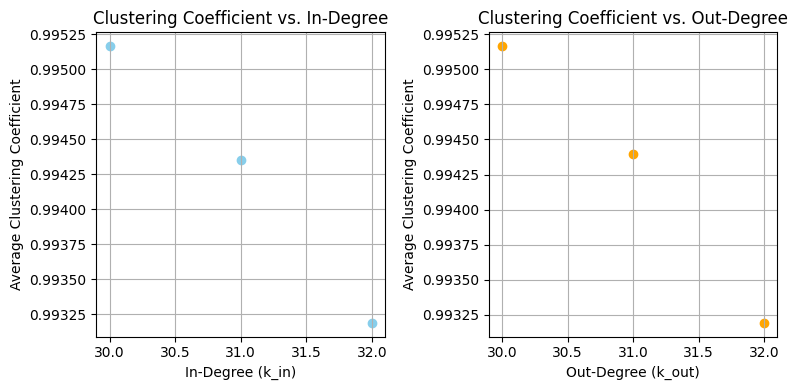

In [53]:
# Compute clustering coefficient, in-degree, and out-degree for each node in the network
clustering_coefficient = nx.clustering(G)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Group nodes by their in-degree and calculate the average clustering coefficient for each in-degree group
in_degree_clustering = {}
for node, k_in in in_degree.items():
    if k_in not in in_degree_clustering:
        in_degree_clustering[k_in] = []
    in_degree_clustering[k_in].append(clustering_coefficient[node])

average_clustering_by_in_degree = {k: np.mean(v) for k, v in in_degree_clustering.items()}

# Group nodes by their out-degree and calculate the average clustering coefficient for each out-degree group
out_degree_clustering = {}
for node, k_out in out_degree.items():
    if k_out not in out_degree_clustering:
        out_degree_clustering[k_out] = []
    out_degree_clustering[k_out].append(clustering_coefficient[node])

average_clustering_by_out_degree = {k: np.mean(v) for k, v in out_degree_clustering.items()}

# Plot the relationship between in-degree and average clustering coefficient
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(average_clustering_by_in_degree.keys(), average_clustering_by_in_degree.values(), color='skyblue')
plt.title('Clustering Coefficient vs. In-Degree')
plt.xlabel('In-Degree (k_in)')
plt.ylabel('Average Clustering Coefficient')
plt.grid(True)

# Plot the relationship between out-degree and average clustering coefficient
plt.subplot(1, 2, 2)
plt.scatter(average_clustering_by_out_degree.keys(), average_clustering_by_out_degree.values(), color='orange')
plt.title('Clustering Coefficient vs. Out-Degree')
plt.xlabel('Out-Degree (k_out)')
plt.ylabel('Average Clustering Coefficient')
plt.grid(True)

plt.tight_layout()
plt.show()

# Question 6

In [65]:
# Calculate the average shortest path length
in_avg_shortest_path_length = nx.average_shortest_path_length(G)
out_avg_shortest_path_length = nx.average_shortest_path_length(G)

# Calculate the average clustering coefficient
in_avg_clustering_coefficient = nx.average_clustering(G)
out_avg_clustering_coefficient = nx.average_clustering(G)

# Print results
print("In-degree:")
print("Average Shortest Path Length:", in_avg_shortest_path_length)
print("Average Clustering Coefficient:", in_avg_clustering_coefficient)

print("\nOut-degree:")
print("Average Shortest Path Length:", out_avg_shortest_path_length)
print("Average Clustering Coefficient:", out_avg_clustering_coefficient)

In-degree:
Average Shortest Path Length: 1.0066287878787878
Average Clustering Coefficient: 0.993423556416187

Out-degree:
Average Shortest Path Length: 1.0066287878787878
Average Clustering Coefficient: 0.993423556416187


# Question 9

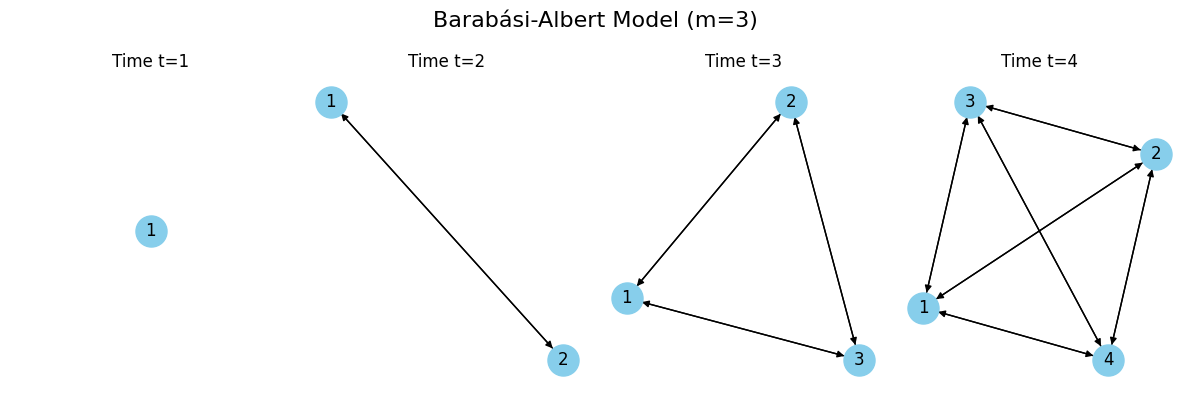

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to update directed graph at each time step
def update_graph(t):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for i in range(1, t+1):
        G.add_node(i)
    
    # Add edges - fully connected in both directions
    for i in range(1, t+1):
        for j in range(1, t+1):
            if i != j:
                G.add_edge(i, j)
                G.add_edge(j, i)
    
    return G

# Define time steps
time_steps = [1, 2, 3, 4]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Iterate over time steps and plot graphs
for i, t in enumerate(time_steps):
    ax = axs[i]
    
    # Update the graph for the current time step
    G = update_graph(t)
    
    # Draw the graph
    nx.draw(G, ax=ax, with_labels=True, node_size=500, node_color='skyblue', font_size=12)
    ax.set_title(f"Time t={t}")

plt.suptitle(f"Barabási-Albert Model (m={3})", fontsize=16)   
plt.tight_layout()
plt.show()

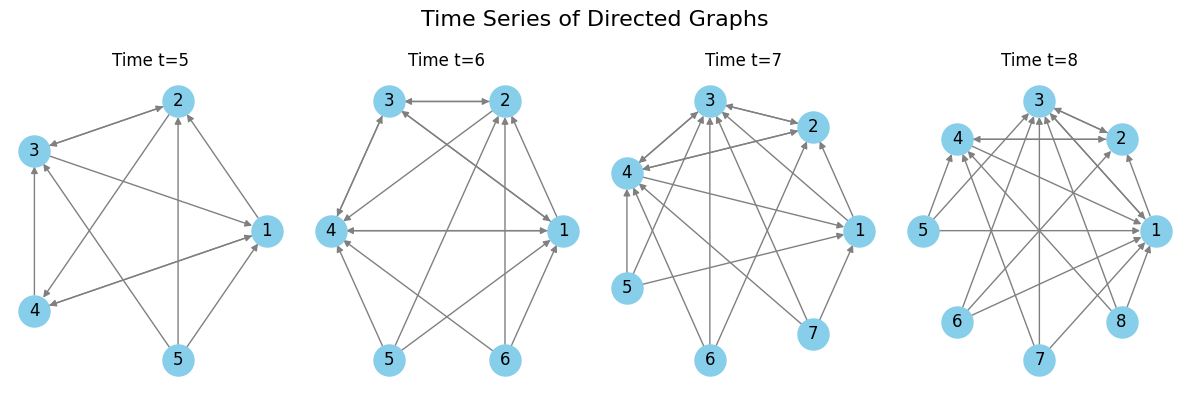

In [8]:
# Define time steps
time_steps = [5, 6, 7, 8]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Iterate over time steps and plot graphs
for i, t in enumerate(time_steps):
    ax = axs[i]
    
    # Update the graph for the current time step
    G = update_graph(t)
    
    # Add edges for t > 4
    if t > 4:
        for i in range(5, t+1):
            # Randomly choose 3 distinct nodes from the first 4 nodes
            nodes_to_connect = np.random.sample(range(1, 5), 3)
            
            # Add directed edges from the new node to the chosen nodes
            for node in nodes_to_connect:
                G.add_edge(i, node)
    
    # Draw the graph with spring layout
    pos = nx.circular_layout(G)
    nx.draw(G, ax=ax, pos=pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, edge_color='gray', arrows=True)
    ax.set_title(f"Time t={t}")

plt.suptitle(f"Time Series of Directed Graphs", fontsize=16)   
plt.tight_layout()
plt.show()
